# Machine Learning with AdaBoost Classifier

# 1. Boosting (AdaBoost)
In this lab you will use a decision tree classifier with max depth=1 as base classifier (weak learner) and use AdaBoost technique to learn a strong classifier. AdaBoost works by putting more weight on difficult to classify instances and less on those already handled well.

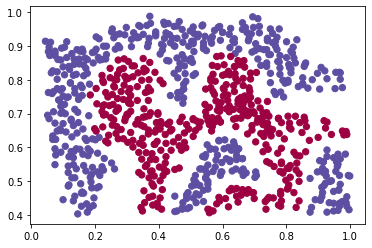

In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from scipy.io import loadmat  
%matplotlib inline

# plot decision boundary
def plot_decision_boundary(model,X):
    # Set min and max values and give it some padding
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    d = np.c_[xx.ravel(), yy.ravel()]

    # Predict the function value for the whole grid
    Z = model.predict(d)
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=.5)


    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

    plt.title('Decision Boundary')
    plt.show()

    
# load data
raw_data = loadmat('ex6data2.mat')
data = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])  
data['y'] = raw_data['y']
X = np.array(data[['X1', 'X2']])
y = np.array(data['y'])

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

## Implementation
Use sklearn.ensemble.AdaBoostClassifier to classify the above dataset. Use decision tree classifier with max depth=1 (aka decision stump) as weak classifier.  

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

dtree = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(base_estimator=dtree)

ada.fit(X, y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1))

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(ada.predict(X), y)

0.9177288528389339

## Question:
AdaBoost works by putting more weight on difficult to classify instances and less on those already handled well. How this information is passed to the weak learner (Decision stump)?

**Answer:** The adaboost trains the individual weak learners, and at any level after training a classifier, the AdaBoost assigns weights to the training item. To handle misclassification, the AdaBoost will assign a higher weight to those items which were misclassified, so that they will appear in the training subset of the next classifier with a higher proability. In this way, the items which are hard to classify are communicated systematically to the next classifiers.
 

## Implementation:
Compute the **unnormalized error rate**, **classifier coefficient** and **updated data weights** for decision stump at m = 2.  

<img src="adaboost.png" style="width:650px;height:300px;">

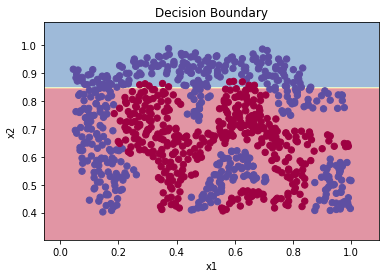

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X, y)

plot_decision_boundary(stump, X)

Below is a self implementation in the form of a `class` of the Ada Boost Classifier with functionality to observe different `Unnormalized Error Rate`, `Classifier Coefficient` and `Updated Weights` on the go. 

Guidance was taken from the following sources during the implementation:
- [University of Torronto Ensemble Methods Slides](https://www.cs.toronto.edu/~urtasun/courses/CSC411/17_ensemble.pdf)
- [Adaboost Implementation repository by Jaime Pastor](https://github.com/jaimeps/adaboost-implementation)

In [109]:
class adaBoostClf():
    def __init__(self, X, y, clf):
        self.X = X
        self.y = y
        self.N = len(self.X)
        # Weight initialization
        self.w = np.ones(self.N) / self.N
        self.y_pred = np.zeros(self.N)
        self.clf = clf
        
    def error_rate(self):
        return sum(self.y_pred != self.y) / float(len(self.y))
    
    def unnormalized_error_rate(self, miss):
        return np.dot(self.w, miss) / sum(self.w)
    
    def classifier_coefficient(self, error_m):
        return 0.5 * np.log( (1 - error_m) / float(error_m))
    
    def update_weight(self, alpha_m, miss2):
        return np.multiply(self.w, np.exp([float(x) * alpha_m for x in miss2]))
    
    def print_unnormalized_error_rate(self, M, error_m):
        print("Unnormalized Error Rate at M={} is {}".format(M, error_m))
        
    def print_classifier_coefficient(self, M, alpha_m):
        print("Classifier Coefficient at M={} is {}".format(M, alpha_m))
        
    def print_updated_weights(self, M):
        print("Upated Weights at M={} are {}".format(M, self.w))
    
    def fit(self, M, output=False, show_updated_weights=False):
        for i in range(M):
            self.clf.fit(self.X, self.y, sample_weight=self.w)
            y_pred_i = self.clf.predict(self.X)
            
            miss = [int(x) for x in (y_pred_i != self.y)]
            miss2 = [x if x==1 else -1 for x in miss]
            
            # Unnormalized Error Rate
            error_m = self.unnormalized_error_rate(miss)
            # Classifier Coefficient
            alpha_m = self.classifier_coefficient(error_m)
            
            # updating weights
            self.w = self.update_weight(alpha_m, miss2)
            
            self.y_pred = [sum(x) for x in zip(self.y_pred, [x * alpha_m for x in y_pred_i])]
            
            if (output):
                self.print_unnormalized_error_rate(i, error_m)
                self.print_classifier_coefficient(i, alpha_m)
                print()
            if (show_updated_weights):
                self.print_updated_weights(i)
        self.y_pred = np.sign(self.y_pred)
        return self.error_rate()

In [110]:
a = adaBoostClf(X,y, stump)

In [111]:
a.fit(M=2, output=True)

Unnormalized Error Rate at M=0 is 0.35921205098493864
Classifier Coefficient at M=0 is 0.28939285202156634

Unnormalized Error Rate at M=1 is 0.35338038849676817
Classifier Coefficient at M=1 is 0.30210656523160234



0.44380069524913096

In [113]:
# Observing weights as they are updated
a.fit(M=2, output=False, show_updated_weights=True)

Upated Weights at M=0 are [0.0008125  0.0008125  0.0008125  0.0008125  0.00045547 0.00055883
 0.00055883 0.00055883 0.00055883 0.00055883 0.00159169 0.00159169
 0.00089227 0.00055883 0.00055883 0.00159169 0.00159169 0.00159169
 0.00159169 0.00055883 0.00055883 0.00055883 0.00089227 0.00159169
 0.00089227 0.00055883 0.00055883 0.00055883 0.00055883 0.00055883
 0.00089227 0.00045547 0.00045547 0.00028526 0.00028526 0.0008125
 0.0008125  0.0008125  0.0008125  0.0008125  0.0008125  0.0008125
 0.0008125  0.0008125  0.0008125  0.0008125  0.0008125  0.0008125
 0.0008125  0.0008125  0.0008125  0.0008125  0.0008125  0.0008125
 0.0008125  0.0008125  0.00028526 0.00028526 0.00028526 0.00045547
 0.0008125  0.0008125  0.00028526 0.00055883 0.00055883 0.00055883
 0.00055883 0.00055883 0.00055883 0.00055883 0.00055883 0.00028526
 0.00028526 0.00028526 0.00055883 0.00055883 0.00055883 0.00055883
 0.00055883 0.00055883 0.00055883 0.00055883 0.00089227 0.00089227
 0.00055883 0.00055883 0.00055883 0.0005

0.44380069524913096